In [25]:
from pandas import read_csv
import numpy as np
import os
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from random import shuffle
import matplotlib.pyplot as plt
import random

In [26]:
def word_stat(text, flag=False):
    t = 24748
    d = dict(Counter(text))
    words = []
    stats = []
    for k, v in d.items():
        if flag:
            words.append(k + t + 1)
        else:
            words.append(k)
        stats.append(v / len(text))
    return words, stats

In [27]:
row_1 = []
col_1 = []
row_2 = []
col_2 = []
data_1 = []
data_2 = []
data_3 = []
data_4 = []
y = []
directory = 'messages'
lst = os.listdir(directory)
random.Random(4).shuffle(lst)
for i, filename in enumerate(lst):
    y.append(int("legit" in filename))
    with open(directory + '/' + filename) as f:
        lines = f.readlines()
        subject = list(map(int, lines[0].rstrip().split()[1:]))
        text = list(map(int, ' '.join(lines[2:]).rstrip().split()))

        w1, s1 = word_stat(subject)
        w2, s2 = word_stat(text, True)
        w3, s3 = word_stat(subject + text)

        col_1 += w1 + w2
        row_1 += [i] * len(w1 + w2)

        data_1 += s1 + s2
        data_2 += list(map(lambda x: 1, s1 + s2))

        col_2 += w3
        row_2 += [i] * len(w3)
        
        data_3 += s3
        data_4 += list(map(lambda x: 1, s3))

In [28]:
num = len(y)
num_train = int(0.8 * num)
num_test = num - num_train

In [29]:
x1 = csr_matrix((data_1, (row_1, col_1)))
x2 = csr_matrix((data_2, (row_1, col_1)))
x3 = csr_matrix((data_3, (row_2, col_2)))
x4 = csr_matrix((data_4, (row_2, col_2)))
x1_train = x1[:num_train]
x2_train = x2[:num_train]
x3_train = x3[:num_train]
x4_train = x4[:num_train]
x1_test = x1[num_train:]
x2_test = x2[num_train:]
x3_test = x3[num_train:]
x4_test = x4[num_train:]
y_train = y[:num_train]
y_test = y[num_train:]


In [30]:
model_1 = MultinomialNB().fit(x1_train, y_train)
model_2 = MultinomialNB().fit(x2_train, y_train)
model_3 = MultinomialNB().fit(x3_train, y_train)
model_4 = MultinomialNB().fit(x4_train, y_train)

In [31]:
test_n = 10
print(model_2.predict(x2_test)[:test_n])
print(y_test[:test_n])

[0 1 1 0 0 1 0 1 1 0]
[0, 1, 1, 0, 0, 1, 0, 1, 1, 0]


In [32]:
def print_roc_auc(x, model):
    probs = model.predict_proba(x)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print(f'AUC score is: {roc_auc}')

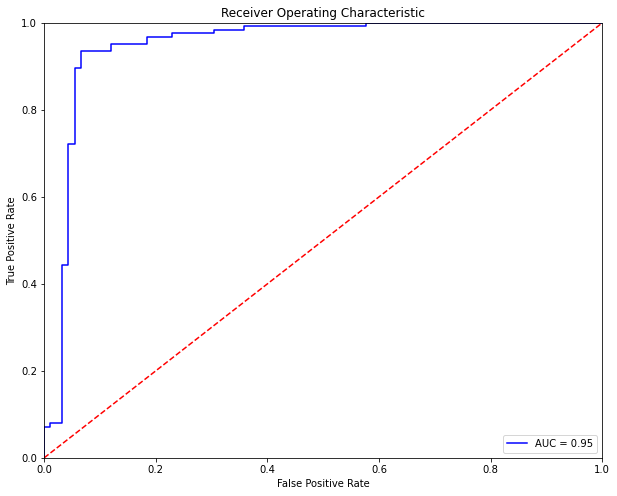

AUC score is: 0.9473775017253278


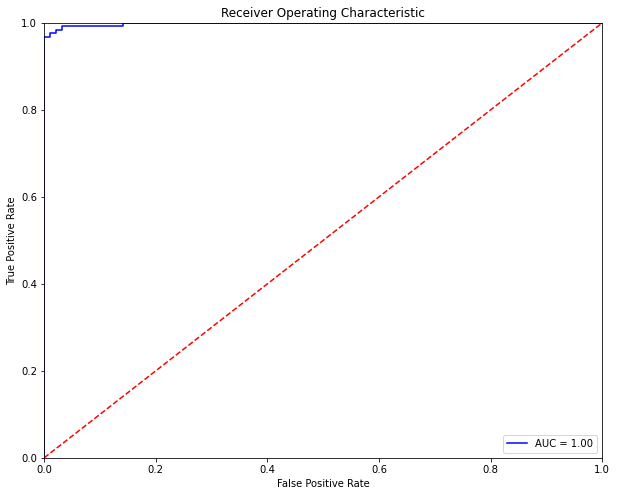

AUC score is: 0.9983609385783299


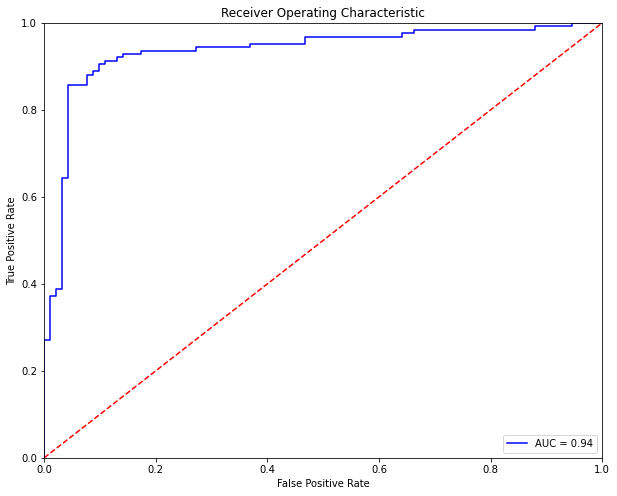

AUC score is: 0.935127674258109


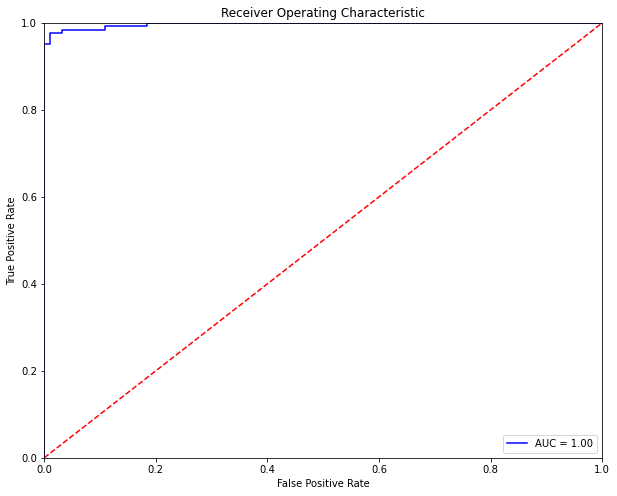

AUC score is: 0.9971532091097308


In [33]:
print_roc_auc(x1_test, model_1)
print_roc_auc(x2_test, model_2)
print_roc_auc(x3_test, model_3)
print_roc_auc(x4_test, model_4)

Лучшая комбинация: учитывать заголовок и тело сообщения по отдельности + смотреть встретилось слово или нет

In [ ]:
best_ppd = []
cnt = 0
xs, ys = [], []
for i in range(1000):
    p = 0.1 ** i
    ppd = [p, 1 - p]
    model = MultinomialNB(class_prior=ppd).fit(x2_train, y_train)
    preds = model.predict(x2_test)
    count = 0
    c = 0
    for i in range(len(preds)):
        if y_test[i] == 1 and preds[i] == 0:
            count += 1
        if y_test[i] == preds[i]:
            c += 1
    if count == 0 and c > cnt:
        best_ppd = ppd
        cnt = c
    xs.append(1 - p)
    ys.append(c)


In [35]:
print(best_ppd, cnt, len(y_test))

[1.0000000000000006e-10, 0.9999999999] 204 218


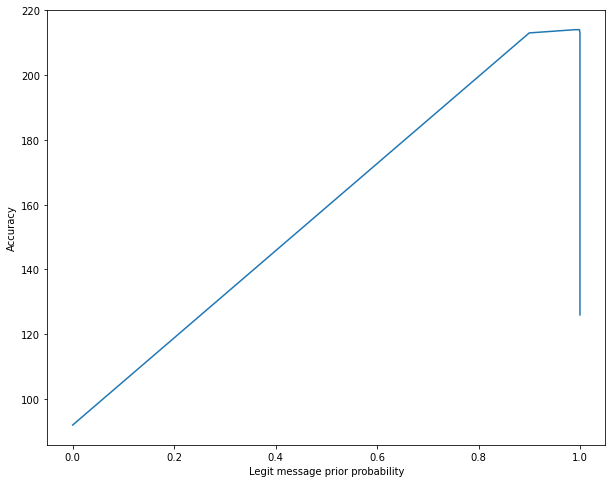

In [36]:
plt.figure(figsize=(10,8))
plt.ylabel('Accuracy')
plt.xlabel('Legit message prior probability')
plt.plot(xs, ys)